# Jax likelihood

Where I try to implement the likelihood function in jax and compare it against existing runs before I try to do a full run for the KN inference.

In [26]:
# Basic imports
import numpy as np
import jax.numpy as jnp
import pandas as pd
import copy
import matplotlib.pyplot as plt
# matlotlib settings
params = {"axes.grid": True,
        "text.usetex" : False, # TODO enable latex, but this breaks if filters have underscore
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}
plt.rcParams.update(params)

# NMMA imports
import nmma as nmma
from nmma.em.io import loadEvent

# flowMC imports
from flowMC.nfmodel.rqSpline import MaskedCouplingRQSpline
from flowMC.sampler.Gaussian_random_walk import GaussianRandomWalk
from flowMC.sampler.MALA import MALA
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys
from flowMC.nfmodel.utils import *

# jax imports
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
import jaxlib
import jax.numpy as jnp
print("Checking if CUDA is found:")
print(jax.devices())

import utils
import json 

Checking if CUDA is found:
[cuda(id=0)]


## Set up model and load data

In [16]:
## Set-up model
# parameters = ['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'KNtheta']
parameters = ['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'inclination_EM']
prior_range = jnp.array([[-3, 1.7], [0.12, 0.25], [0.15, 0.3], [-2, 0.89], [-2, -0.89], [0, jnp.pi / 2]])
n_dim = len(prior_range)

# Load data
data_file = "../data/AT2017gfo_no_inf.dat"
trigger_time = 57982.5285236896
tmin, tmax = 0.05, 14
data = loadEvent(data_file)
filters = list(data.keys())
print("Filters: ", filters)
sample_times = jnp.linspace(tmin, tmax, 1_000)

## Posterior samples

In [29]:
# Load the posterior from a run by Peter
cpu_posterior_file = "../cpu_runs/Bu2022Ye_uniform_iota/outdir/AT2017gfo_Bu2022Ye_uniform_iota_result.json"
with open(cpu_posterior_file, "r") as f:
    cpu_posterior_json = json.load(f)
cpu_posterior = cpu_posterior_json["posterior"]["content"]
print(cpu_posterior.keys())

dict_keys(['inclination_EM', 'log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'timeshift', 'luminosity_distance', 'Ebv', 'log_likelihood', 'log_prior'])


Load the samples and get the maximum likelihood sample

In [30]:
posterior_samples = np.array([cpu_posterior[param] for param in parameters])
posterior_samples = posterior_samples.T

log_likelihood_cpu = cpu_posterior["log_likelihood"]

# Get the maximum likelihood parameters
max_likelihood_idx = np.argmax(log_likelihood_cpu)
max_likelihood_params = posterior_samples[max_likelihood_idx]

## Test LC generation

In [32]:
print("max_likelihood_params")
for i, p in enumerate(parameters):
    print(f"{p}: {max_likelihood_params[i]}")

_, _, lc_max_likelihood = utils.calc_lc_given_params_jit(max_likelihood_params)
lc_max_likelihood_params_dict = {f: np.asarray(lc_max_likelihood[f]) for f in utils.filters}

max_likelihood_params
log10_mej_dyn: -2.998431844478561
vej_dyn: 0.1298740818913512
Yedyn: 0.16264697303255118
log10_mej_wind: -1.347868718076242
vej_wind: 0.030187987224515975
inclination_EM: 0.004215726729039513


In [34]:
lc_max_likelihood_params_dict

{'ps1__g': array([ 1.14353497e+01,  4.90037161e+00, -1.63460646e+00, -8.16958454e+00,
        -1.47045626e+01, -1.64420052e+01, -1.65956320e+01, -1.66277785e+01,
        -1.66006803e+01, -1.65205933e+01, -1.64460339e+01, -1.63810683e+01,
        -1.63318686e+01, -1.62686465e+01, -1.62251320e+01, -1.61815652e+01,
        -1.61326648e+01, -1.60993067e+01, -1.60745534e+01, -1.60535744e+01,
        -1.60341005e+01, -1.60137621e+01, -1.59841158e+01, -1.59581879e+01,
        -1.59408604e+01, -1.59277911e+01, -1.59136614e+01, -1.58934219e+01,
        -1.58741174e+01, -1.58560570e+01, -1.58383508e+01, -1.58209148e+01,
        -1.58085004e+01, -1.57989907e+01, -1.57864532e+01, -1.57715054e+01,
        -1.57583580e+01, -1.57478186e+01, -1.57375349e+01, -1.57326576e+01,
        -1.57277803e+01, -1.57241360e+01, -1.57212787e+01, -1.57184215e+01,
        -1.57231324e+01, -1.57281534e+01, -1.57320862e+01, -1.57325606e+01,
        -1.57330351e+01, -1.57303340e+01, -1.57203361e+01, -1.57103381e+01,
  

No handles with labels found to put in legend.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Serif


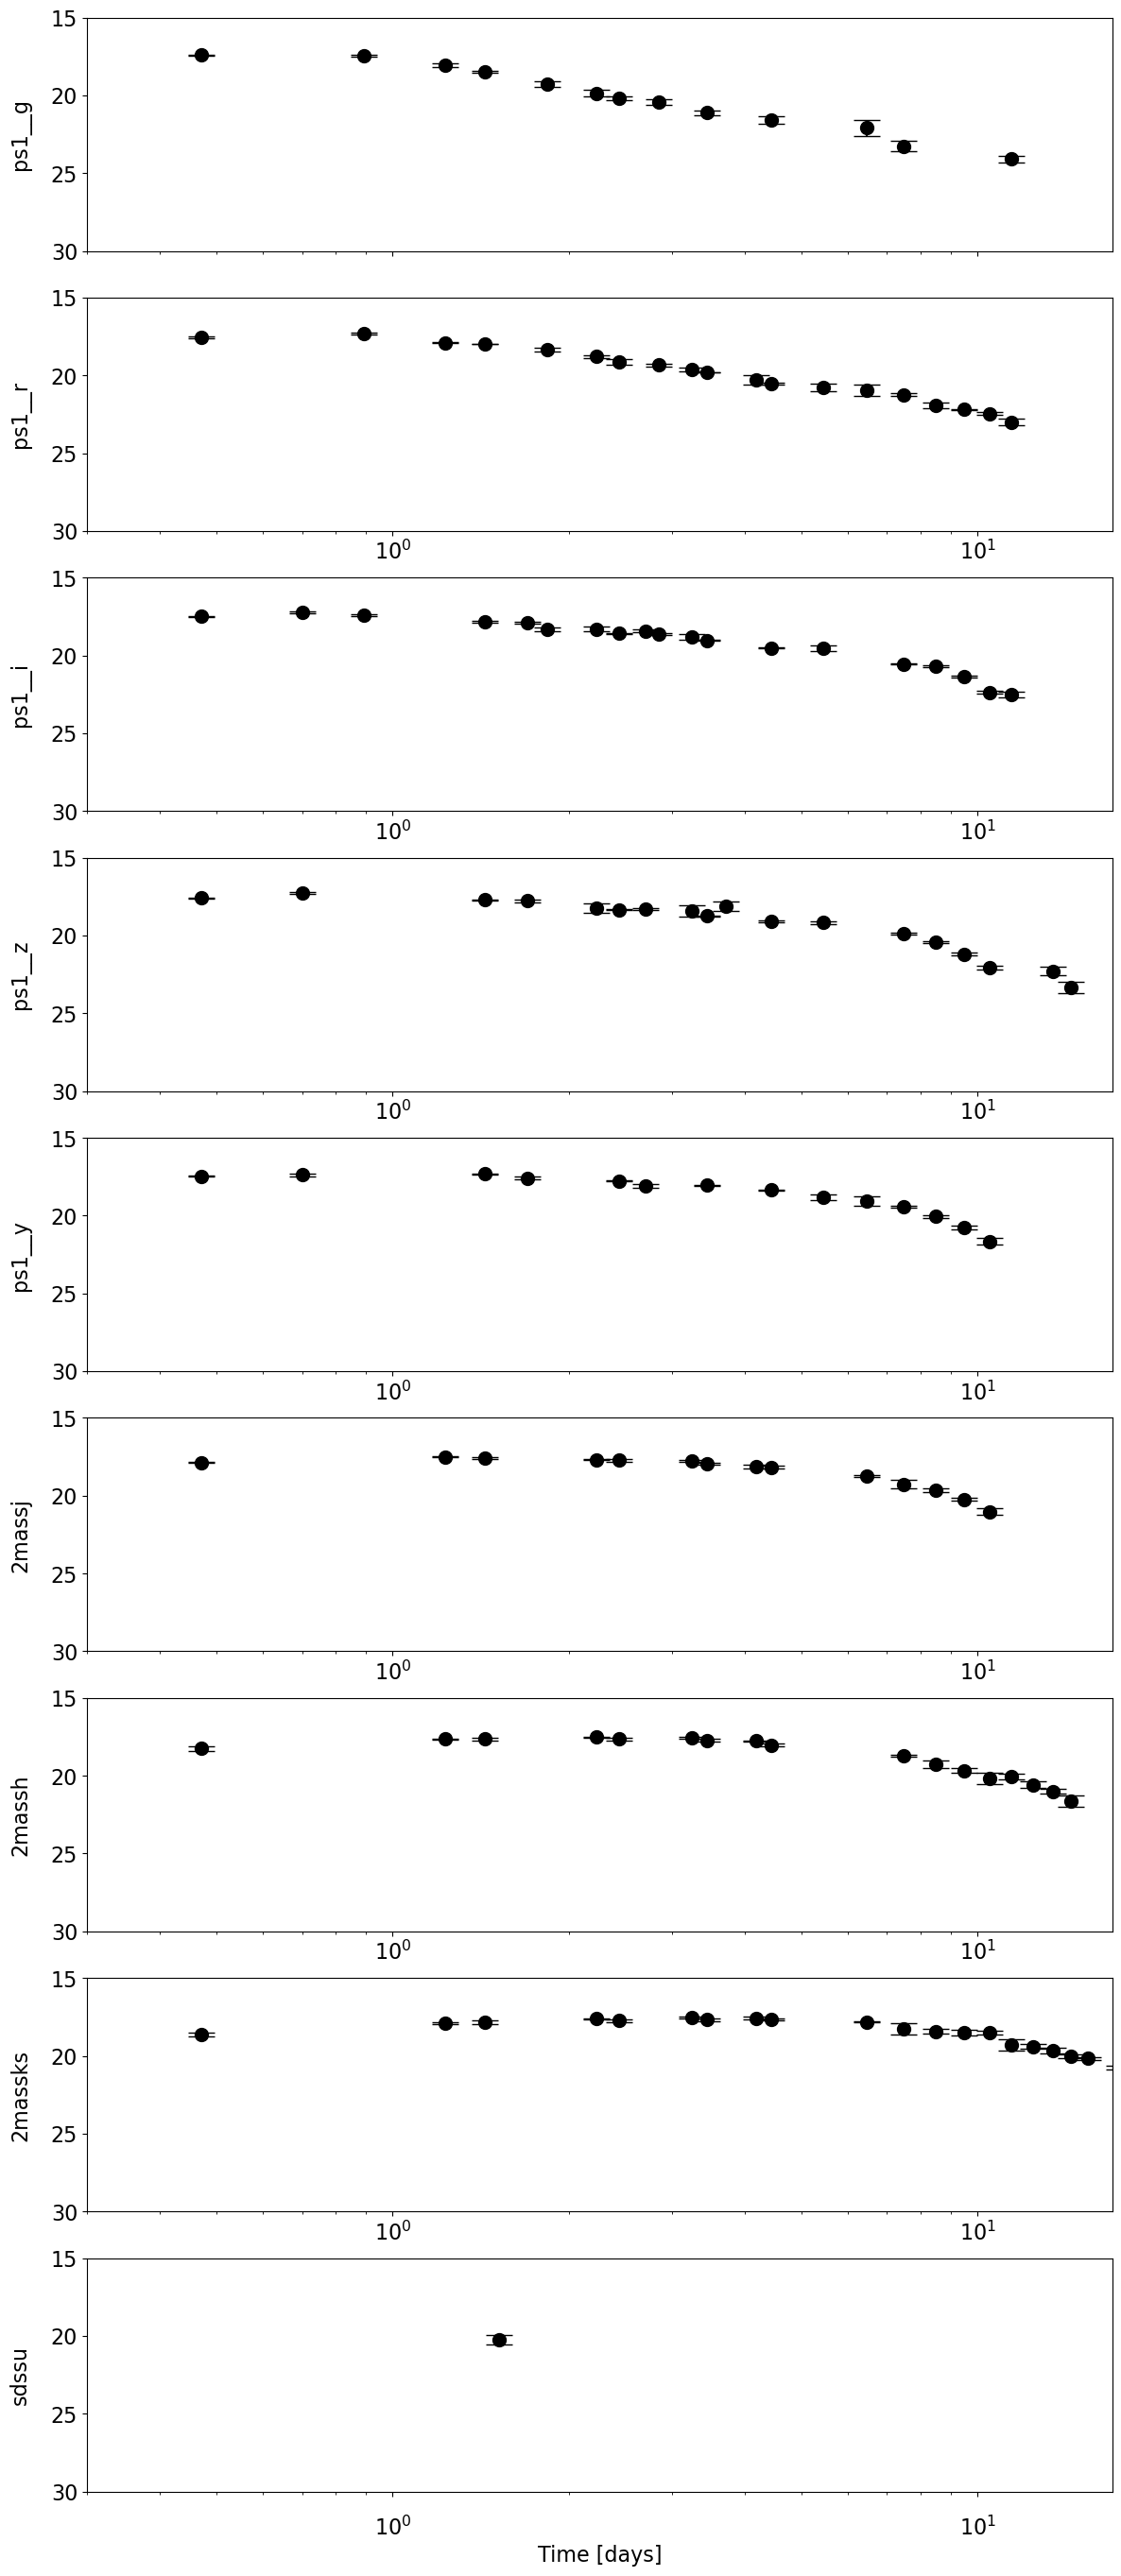

In [33]:
### Plot hyperparameters
set_ylim = True
set_yticks = True
show_legend = False
show_data = True

error_budget = '1.0'
error_budget = [float(x) for x in error_budget.split(",")]
error_budget = dict(zip(filters, error_budget * len(filters)))
xlim = f"{tmin},{tmax}"
ylim = "32, 15"
x_left = 3e-1
x_right = tmax + 3

# colors = cm.Spectral(np.linspace(0, 1, len(filters)))[::-1]

plt.figure(figsize=(14, 34))

cnt = 0
for filt in filters:
    cnt = cnt + 1
    if cnt == 1:
        ax1 = plt.subplot(len(filters), 1, cnt)
    elif cnt == 2 or cnt == 3:
        ax2 = plt.subplot(len(filters), 1, cnt, sharex=ax1)
    else:
        ax2 = plt.subplot(len(filters), 1, cnt, sharex=ax1)

    samples = data[filt]
    t, y, sigma_y = copy.deepcopy(samples[:, 0]), copy.deepcopy(samples[:, 1]), copy.deepcopy(samples[:, 2])
    t -= trigger_time   
    idx = np.where(~np.isnan(y))[0]
    t, y, sigma_y = t[idx], y[idx], sigma_y[idx]

    # 1) plot data points
    idx = np.where(np.isfinite(sigma_y))[0]
    plt.errorbar(t[idx], y[idx], sigma_y[idx], fmt="o", color='k', markersize=10, capsize=10)
    # plot upper bounds
    idx = np.where(~np.isfinite(sigma_y))[0]
    plt.errorbar(t[idx], y[idx], sigma_y[idx], fmt="v", color='k', markersize=10, capsize=10)

    # 2) plot model
    my_mag = lc_max_likelihood_params_dict[filt]
    plt.plot(utils.sample_times, my_mag, color="red")

    #plt.ylim([float(x) for x in ylim.split(",")])
    plt.xlim([float(x) for x in xlim.split(",")])
    plt.xscale('log')
    plt.grid()
    
    filt_label = filt
    
    if cnt == 1:
        
        plt.ylabel(filt_label, rotation=90, labelpad=15)
        if set_ylim:
            ax1.set_ylim([30,15])
        #plt.ylim([float(x) for x in ylim.split(",")])
    else:
        # filt_label = filt.replace("__", "-")
        plt.ylabel(filt_label, rotation=90, labelpad=15)
        if set_ylim:
            ax2.set_ylim([30,15])
        #plt.ylim([float(x) for x in ylim.split(",")])

    if cnt == 1:
        if set_yticks:
            ax1.set_yticks([30, 25, 20, 15])
        else:
            ax1.invert_yaxis()
        ax1.set_xlim(left=x_left, right=x_right)
        plt.setp(ax1.get_xticklabels(), visible=False)
        legend = plt.legend(loc = "center", bbox_to_anchor=(0.5, 1.2), shadow=False,
                            fancybox=True, ncol=4)
        legend.get_frame().set_alpha(None)
    else:
        if set_yticks:
            ax2.set_yticks([30, 25, 20, 15])
        else:
            ax2.invert_yaxis()
        ax2.set_xlim(left=x_left, right=x_right)
    

ax1.set_zorder(1)
plt.xlabel("Time [days]")
ax2.tick_params(axis='x', which='major', pad=15)
#plt.legend(bbox_to_anchor=(0., 12.9, 1.025, .0), ncol=2, fontsize=40, frameon=True)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0)

if not show_legend:
    legend.remove()

if show_data:
    plt.show()
else:
    plt.close()

## Inference with flowMC

### Priors

Look at `/home/urash/twouters/gpu_projects/KN_inference/cpu/priors/AT2017gfo_Bu2022Ye_uniform_iota.prior`:
```markdown
luminosity_distance = 44
inclination_EM = Uniform(name='inclination_EM', minimum=0., maximum=np.pi/2., latex_label='$\\iota$')
log10_mej_dyn  = Uniform(name='log10_mej_dyn', minimum=-3, maximum=-1.7, latex_label='$\\log_{10}M^{\\rm{dyn}}_{\\rm{ej}}$')
vej_dyn = Uniform(name='vej_dyn', minimum=0.12, maximum=0.25, latex_label='$V^{\\rm{dyn}}_{\\rm{ej}}$')
Yedyn = Uniform(name='Yedyn', minimum=0.15, maximum=0.3, latex_label='$Y_{\\rm{e}}$')
log10_mej_wind = Uniform(name='log10_mej_wind', minimum=-2, maximum=-0.89, latex_label='$\\log_{10}M^{\\rm{wind}}_{\\rm{ej}}$')
vej_wind = Uniform(name='vej_wind', minimum=0.03, maximum=0.15, latex_label='$V^{\\rm{wind}}_{\\rm{ej}}$')
```

In [4]:


# Make data a jnp array
for filt in utils.filters:
    utils.data[filt] = jnp.asarray(utils.data[filt])

## Likelihood

In [6]:
# Get some dummy values for the parameters
filt = utils.filters[0]
data_mag = copy.deepcopy(utils.data[filt][:, 1])
data_sigma = copy.deepcopy(utils.data[filt][:, 2])
error_budget = 1.0
detection_limit = jnp.inf
data_sigma = jnp.sqrt(data_sigma ** 2 + error_budget ** 2)

# dummy estimated magnitudes
mag_est = data_mag + 0.1

def test_truncated_gaussian(data_mag,
            data_sigma,
            mag_est,
            detection_limit):
    """
    Test the truncated gaussian function
    """

    return jnp.sum(
        utils.truncated_gaussian(
            data_mag,
            data_sigma,
            mag_est,
            detection_limit,
        )
    )

In [7]:
print(test_truncated_gaussian(data_mag, data_sigma, mag_est, detection_limit))
print(jax.grad(test_truncated_gaussian)(data_mag, data_sigma, mag_est, detection_limit))

-12.304478773133997
[0.09996002 0.09936407 0.09858044 0.09984026 0.09719118 0.09577627
 0.09880447 0.0975039  0.0975039  0.09538344 0.07871537 0.08963786
 0.09615385]


Checking likelihood computation and gradient

In [11]:
print("Test for random params")
print(test_params)
test_logL = utils.log_likelihood(test_params)
print(test_logL)

Test for random params
[-2.30103  0.12     0.3     -1.30103  0.03    25.84   ]
-87354960718.77606


In [12]:
test_dv_logL = jax.grad(utils.log_likelihood)(test_params)
print(test_dv_logL)

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(sub). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

### Posterior

In [25]:
def posterior(theta, data):
    # NOTE: the data argument is unused?
    prior = top_hat(theta)
    return log_likelihood(theta) + prior

### Set up sampler

Initial position of chains

In [26]:
n_chains = 100

rng_key_set = initialize_rng_keys(n_chains, seed=42)

initial_position = jax.random.uniform(rng_key_set[0], shape=(int(n_chains), n_dim)) * 1
for i in range(n_dim):
    initial_position = initial_position.at[:,i].set(initial_position[:,i]*(prior_range[i,1]-prior_range[i,0])+prior_range[i,0])

In [27]:
model = MaskedCouplingRQSpline(n_dim, 10, [128,128], 8, jax.random.PRNGKey(42))

print("Initializing sampler class")

mass_matrix = jnp.eye(n_dim)
eps = 1e-3
# TODO any tuning to be done here?
posterior = posterior

local_sampler_arg = {"step_size": mass_matrix * eps}
use_jit = True
# local_sampler = MALA(posterior, use_jit, local_sampler_arg) ## TODO derivative is broken so MALA is broken
local_sampler = GaussianRandomWalk(posterior, use_jit, {"step_size": eps})

Initializing sampler class


### Run the sampler

In [28]:
nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    None,
    local_sampler,
    model,
    n_loop_training=50,
    n_loop_production=10,
    n_local_steps=20,
    n_global_steps=20,
    n_chains=n_chains,
    n_epochs=100,
    learning_rate=0.001,
    max_samples=50000,
    momentum=0.9,
    batch_size=50000,
    use_global=True,
    keep_quantile=0.0,
    train_thinning=1,
    output_thinning=1,    
    local_sampler_arg=local_sampler_arg,
    outdir_name="./outdir/"
)

## Run sampler

Note: without jitting, we get more print statements (as expected since that is a byproduct of the function), and the training loop takes around 4 minutes, production loop around 2 mins.

In [29]:
# nf_sampler.sample(initial_position, None)

No autotune found, use input sampler_params
Training normalizing flow


Tuning global sampler:   0%|          | 0/50 [00:10<?, ?it/s]


KeyboardInterrupt: 

## Postprocessing

In [ ]:
# print("Creating plots")
# nf_sampler.plot_summary("training")
# nf_sampler.plot_summary("production")

Creating plots


NameError: name 'nf_sampler' is not defined

## TODO, can we do inference with Numpyro?

**TODO**: Install numpyro and make sure it does not break the conda env again

**TODO**: Get likelihood etc?

In [ ]:
# import numpyro
# from numpyro.diagnostics import hpdi, summary
# import numpyro.distributions as dist
# from numpyro import handlers
# from numpyro.infer import MCMC, NUTS
# numpyro.set_platform("gpu")

In [ ]:
# def run_inference(
#     model, num_warmup=1000, num_samples=1000, max_tree_depth=10, dense_mass=False
# ):
#     kernel = NUTS(model, max_tree_depth=max_tree_depth, dense_mass=dense_mass)
#     mcmc = MCMC(
#         kernel,
#         num_warmup=num_warmup,
#         num_samples=num_samples,
#         num_chains=1,
#         progress_bar=False,
#     )
#     mcmc.run(jax.random.PRNGKey(0))
#     summary_dict = summary(mcmc.get_samples(), group_by_chain=False)

#     # print the largest r_hat for each variable
#     for k, v in summary_dict.items():
#         spaces = " " * max(12 - len(k), 0)
#         print("[{}] {} \t max r_hat: {:.4f}".format(k, spaces, np.max(v["r_hat"])))